# rare-common network colocalization

generate network colocalization values

# setup

In [1]:
#read in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2 
import scipy.stats as stats
import matplotlib
from scipy.stats import hypergeom
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import os
import sys
from rca_functions import *

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
os.chdir('../')

In [4]:
save_file=False
save_fig=False

cutoff_comb=3
cutoff_single=1.5

## Interactome Set-up

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


In [6]:
interactome_name='pcnet_v14'
UUIDs #imported from rca_functions

{'pcnet_v14': 'c3554b4e-8c81-11ed-a157-005056ae23aa',
 'pcnet_v13': '4de852d9-9908-11e9-bcaf-0ac135e8bacf',
 'string': '98ba6a19-586e-11e7-8f50-0ac135e8bacf',
 'humanNet_v3_FN': '40913318-3a9c-11ed-ac45-0ac135e8bacf',
 'ACN': 'f81a3f67-4215-11ee-aa50-005056ae23aa',
 'ACN_strin': '48de252c-3d50-11ee-aa50-005056ae23aa'}

In [7]:
interactome=import_interactome(interactome_name)
interactome_nodes=list(interactome.nodes())

pcnet_v14
number of nodes:
18630

number of edges:
2687393


# Run looped analysis

loops through the chosen rare and common datasets to calculate the overlapping network, and subsequent statstical secondary analyses

## import metadata for datasets- includes delimiters, column names, file names, etc.

In [8]:
common_datasets=pd.read_csv('common_datasets_prepub.csv',sep=',')
rare_datasets=pd.read_csv('rare_datasets_prepub.csv',sep=',')

### define samples you want to run

#### common datasets

In [9]:
#subset datasets from common variants that you want to analyze
common_datasets=common_datasets[0:1]
common_datasets=common_datasets.reset_index()
common_datasets 

,index,group,snp2gene_method,label,phenotype_group,seed_path,delim,zscore_file,zscore_path,seed_p,seed_gene_name,description,cutoff
0,0,GSCAN_DPW,magma,GSCAN_DPW_magma,alcohol,GSCAN_DPW/GSCAN_DPW_magma_results.csv,comma,gscan_dpw_magma_zscore.tsv,network_scores/gscan_dpw_magma_zscore.tsv,P,GENE_NAME,drinks_per_week_gscan,bonferroni


In [10]:
#subset datasets from rare variants that you want to analyze
rare_datasets=rare_datasets[0:1]
rare_datsets=rare_datasets.reset_index()
rare_datasets 

,label,cutoff used,seed_path,delim,zscore_file,zscore_path,Unnamed: 6,seed_gene_name,phenotype_group
0,alcoholintake_FDR_25,all tests FDR <0.25,rare_variant_genebass/alcohol_intake/alcohol_i...,comma,alcoholintake_fdr_25_zscore.tsv,network_scores/alcoholintake_FDR_25_zscore.tsv,network_scores/alcoholintake_fdr_25_zscore.tsv,Gene Name,alcohol


## histogram

generate histograms of the NPS scores from the rare and common datasets, with and without seed genes, combined NPS scores, and scatter plot of NPS scores

analyzing rare dataset: alcoholintake_FDR_25
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
   Unnamed: 0 Gene Name
0           0      PMM2
1           1   SLC29A1
2           2     SCN7A
3           3    ATP2B1
4           4     MMEL1
importing file: calculated_values/network_scores/alcoholintake_fdr_25_zscore.tsv
               z
0               
UBE2Q1 -0.900155
RNF14  -1.262321
UBE2Q2 -0.826430
TMCO1  -1.503556
UBAC1   0.528793
analyzing common dataset: GSCAN_DPW_magma
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-0

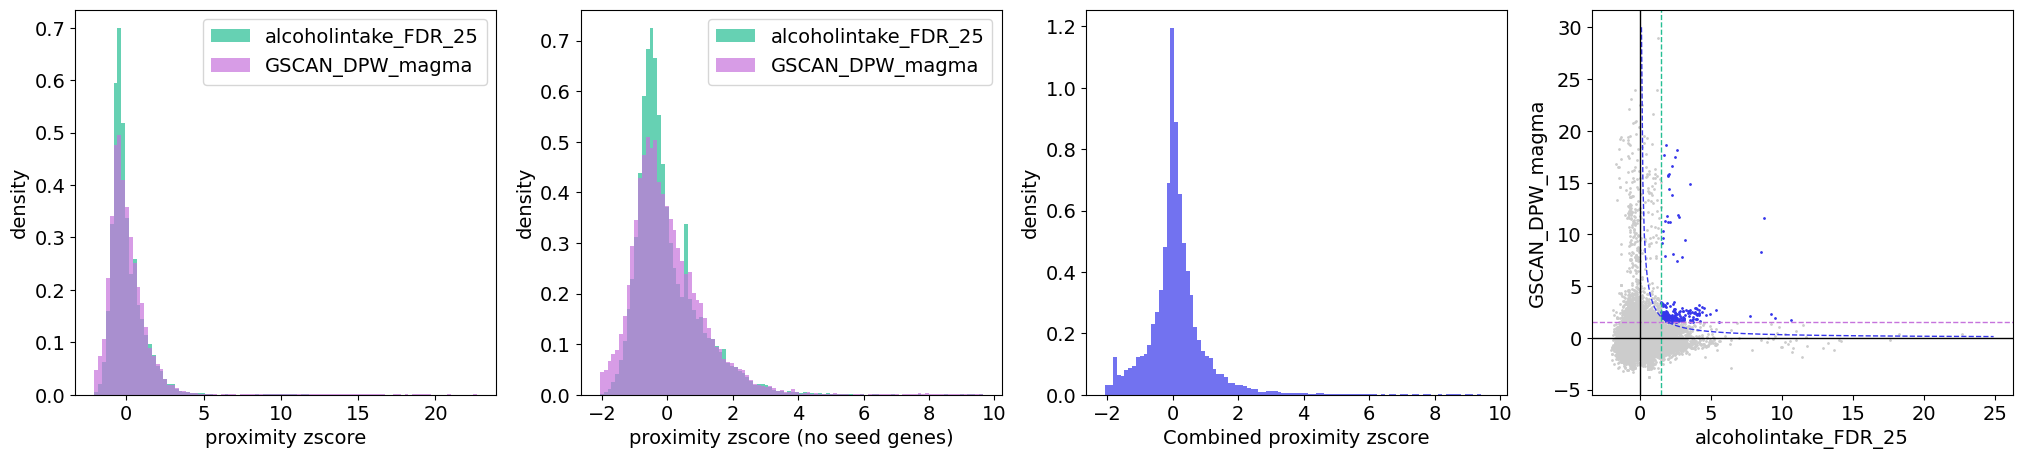

<Figure size 640x480 with 0 Axes>

In [11]:
for row_rare in range(len(rare_datasets)):
    #import rare seed gene list and NPS scores
    label_rare=rare_datasets['label'][row_rare]
    print('analyzing rare dataset: '+label_rare)
    seed_rare=import_seedgenes(path='input_files/'+rare_datasets['seed_path'][row_rare],
                               pcol=None,
                               gene_col=rare_datasets['seed_gene_name'],
                                delim=rare_datasets['delim'][row_rare])
    seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][row_rare]]))
    zscore_rare_df=import_nps_zscores(z_path='calculated_values/'+rare_datasets['zscore_path'][row_rare], interactome_name='pcnet_v14')
    for row_common in range(len(common_datasets)):
        label_common=common_datasets['label'][row_common]
        print('analyzing common dataset: '+label_common)
        seed_common=import_seedgenes(path='input_files/'+common_datasets['seed_path'][row_common],
                                    pcol=common_datasets['seed_p'][row_common], 
                                    gene_col=common_datasets['seed_gene_name'][row_common],
                                    delim=common_datasets['delim'][row_common],
                                    cutoff=common_datasets['cutoff'][row_common])
        zscore_common_df=import_nps_zscores(z_path=('calculated_values/'+common_datasets['zscore_path'][row_common]), interactome_name='pcnet_v14')

        plt_histogram(zscore_rare_df, zscore_common_df, str(label_rare), str(label_common),seed_rare,seed_common, 1.5, 1.5,3, save_fig)
        plt.clf()


## loop venn diagram seeds

analyzing rare dataset: alcoholintake_FDR_25
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
   Unnamed: 0 Gene Name
0           0      PMM2
1           1   SLC29A1
2           2     SCN7A
3           3    ATP2B1
4           4     MMEL1
analyzing common dataset: GSCAN_DPW_magma
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-07     AGMAT  
203  1.769100e-08      DDI2  
204  9.774400e-09    RSC1A1  
205  2.008100e-11   PLEKHM2  
465  1.814100e-06   A3GALT2  
N rare seed genes- alcoholintake_FDR_25: 32
N common seed genes- G

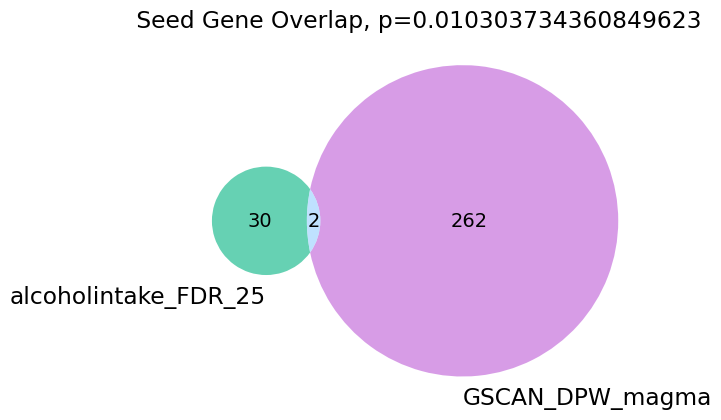

<Figure size 640x480 with 0 Axes>

In [12]:
for row_rare in range(len(rare_datasets)):
    #import rare seed gene list and NPS scores
    label_rare=rare_datasets['label'][row_rare]
    print('analyzing rare dataset: '+label_rare)
    seed_rare=import_seedgenes(path='input_files/'+rare_datasets['seed_path'][row_rare],
                               pcol=None,
                               gene_col=rare_datasets['seed_gene_name'],
                                delim=rare_datasets['delim'][row_rare])
    seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][row_rare]]).intersection(interactome_nodes))
    for row_common in range(len(common_datasets)):
        label_common=common_datasets['label'][row_common]
        print('analyzing common dataset: '+label_common)
        seed_common=import_seedgenes(path='input_files/'+common_datasets['seed_path'][row_common],
                                    pcol=common_datasets['seed_p'][row_common], 
                                    gene_col=common_datasets['seed_gene_name'][row_common],
                                    delim=common_datasets['delim'][row_common],
                                    cutoff=common_datasets['cutoff'][row_common])
        seed_common=list(set(seed_common[common_datasets['seed_gene_name'][row_common]]).intersection(interactome_nodes))
        
        print('N rare seed genes- '+label_rare+': '+str(len(set(seed_rare))))
        print('N common seed genes- '+label_common+': '+str(len(set(seed_common))))
        print(set(seed_rare).intersection(set(seed_common)))

        venn_seeds(seed_rare,seed_common,label_rare, label_common, interactome_nodes)        
        plt.clf()


## Loop network colocalization, and net coloc venn diagram

In [13]:
#set the Z-score cutoffs to calculate network enrichment significance
zlist = [1,2,3,5]
z12list = [1,1.5,2]

analyzing rare dataset: alcoholintake_FDR_25
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
   Unnamed: 0 Gene Name
0           0      PMM2
1           1   SLC29A1
2           2     SCN7A
3           3    ATP2B1
4           4     MMEL1
importing file: calculated_values/network_scores/alcoholintake_fdr_25_zscore.tsv
               z
0               
UBE2Q1 -0.900155
RNF14  -1.262321
UBE2Q2 -0.826430
TMCO1  -1.503556
UBAC1   0.528793
analyzing common dataset: GSCAN_DPW_magma
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-0

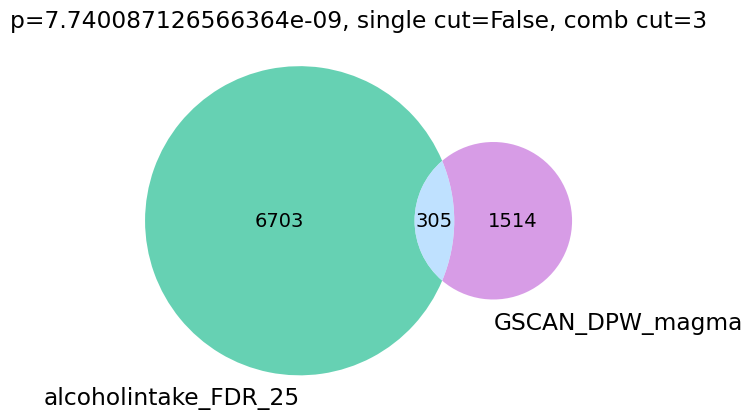

<Figure size 640x480 with 0 Axes>

In [14]:
for row_rare in range(len(rare_datasets)):
    label_rare=rare_datasets['label'][row_rare]
    print('analyzing rare dataset: '+label_rare)
    #import rare seed gene list and NPS scores
    seed_rare=import_seedgenes(path='input_files/'+rare_datasets['seed_path'][row_rare],
                               pcol=None,
                               gene_col=rare_datasets['seed_gene_name'],
                                delim=rare_datasets['delim'][row_rare])
    seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][row_rare]]))
    zscore_rare_df=import_nps_zscores(z_path='calculated_values/'+rare_datasets['zscore_path'][row_rare], interactome_name='pcnet_v14')
    for row_common in range(len(common_datasets)):
        label_common=common_datasets['label'][row_common]
        print('analyzing common dataset: '+label_common)
        #import common seed gene list and NPS scores
        seed_common=import_seedgenes(path='input_files/'+common_datasets['seed_path'][row_common],
                                    pcol=common_datasets['seed_p'][row_common], 
                                    gene_col=common_datasets['seed_gene_name'][row_common],
                                    delim=common_datasets['delim'][row_common],
                                    cutoff=common_datasets['cutoff'][row_common])
        zscore_common_df=import_nps_zscores(z_path='calculated_values/'+common_datasets['zscore_path'][row_common], interactome_name='pcnet_v14')
        #calculate network enrichment
        netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(zscore_rare_df,zscore_common_df,
                                                                                     zthresh_list = zlist,
                                                                                     z12thresh_list=z12list,
                                                                                     verbose=False)
        netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['z_12']]
        print(netcoloc_enrichment_df)
        if save_fig:
            netcoloc_enrichment_df.to_csv('colocalization_scores/colocScore_'+label_common+'_'+label_common+UUID_tag[interactome_name]+'.tsv',sep='\t')
        
        pOverlap=float(netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==cutoff_comb) & (netcoloc_enrichment_df['z_12']==cutoff_single)]['empirical_p'])
        #plot venn diagram of network overlap
        venn_net(zscore_rare_df['z'].squeeze(), zscore_common_df['z'].squeeze(), label_rare, label_common, pOverlap, save_fig)
        
        plt.clf()


## Loop generating networks- save to ndexbio

In [15]:
for row_rare in range(len(rare_datasets)):
    label_rare=rare_datasets['label'][row_rare]
    print('analyzing rare dataset: '+label_rare)
    #import rare seed gene list and NPS scores
    seed_rare=import_seedgenes(path='input_files/'+rare_datasets['seed_path'][row_rare],
                               pcol=None,
                               gene_col=rare_datasets['seed_gene_name'],
                                delim=rare_datasets['delim'][row_rare])
    seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][row_rare]]))
    zscore_rare_df=import_nps_zscores(z_path='calculated_values/'+rare_datasets['zscore_path'][row_rare], interactome_name='pcnet_v14')
    for row_common in range(len(common_datasets)):
        label_common=common_datasets['label'][row_common]
        print('analyzing common dataset: '+label_common)
        #import common seed gene list and NPS scores
        seed_common=import_seedgenes(path='input_files/'+common_datasets['seed_path'][row_common],
                                    pcol=common_datasets['seed_p'][row_common], 
                                    gene_col=common_datasets['seed_gene_name'][row_common],
                                    delim=common_datasets['delim'][row_common],
                                    cutoff=common_datasets['cutoff'][row_common])
        zscore_common_df=import_nps_zscores(z_path='calculated_values/'+common_datasets['zscore_path'][row_common], interactome_name='pcnet_v14')

        #generate subgraph
        net=network_colocalization.calculate_network_overlap_subgraph(interactome, zscore_rare_df['z'].squeeze(), zscore_common_df['z'].squeeze(), cutoff_comb, cutoff_single, cutoff_single)
        net2=format_network(net, label_rare, label_common, seed_rare , seed_common, zscore_rare_df['z'].squeeze(), zscore_common_df['z'].squeeze())
        print(net2.nodes())
        if save_fig:
            print('exporting network to NDEx')
            export_network(network=net, name=(label_rare+'_'+label_common+'_'+UUID_tag[interactome_name]), user=ndex_user, password=ndex_password)
        

analyzing rare dataset: alcoholintake_FDR_25
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
   Unnamed: 0 Gene Name
0           0      PMM2
1           1   SLC29A1
2           2     SCN7A
3           3    ATP2B1
4           4     MMEL1
importing file: calculated_values/network_scores/alcoholintake_fdr_25_zscore.tsv
               z
0               
UBE2Q1 -0.900155
RNF14  -1.262321
UBE2Q2 -0.826430
TMCO1  -1.503556
UBAC1   0.528793
analyzing common dataset: GSCAN_DPW_magma
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-0

analyzing rare dataset: alcoholintake_FDR_25
pvalue column not specified- all genes will be used
cutoff not defined/custom- using all genes 
   Unnamed: 0 Gene Name
0           0      PMM2
1           1   SLC29A1
2           2     SCN7A
3           3    ATP2B1
4           4     MMEL1
importing file: calculated_values/network_scores/alcoholintake_fdr_25_zscore.tsv
               z
0               
UBE2Q1 -0.900155
RNF14  -1.262321
UBE2Q2 -0.826430
TMCO1  -1.503556
UBAC1   0.528793
analyzing common dataset: GSCAN_DPW_magma
       GENE  CHR     START      STOP  NSNPS  NPARAM       N   ZSTAT  \
202   79814    1  15561699  15595110    199      19  628831  4.9260   
203   84301    1  15607458  15671057    215      18  618929  5.5125   
204    6248    1  15649869  15671722     63      10  625701  5.6159   
205   23207    1  15674267  15744769    299      32  623320  6.6035   
465  127550    1  33296766  33331098    137      27  614472  4.6316   

                P GENE_NAME  
202  4.195900e-0

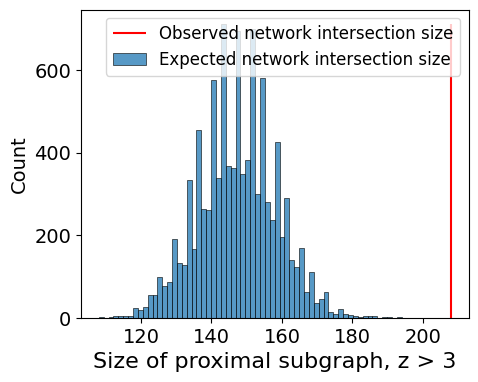

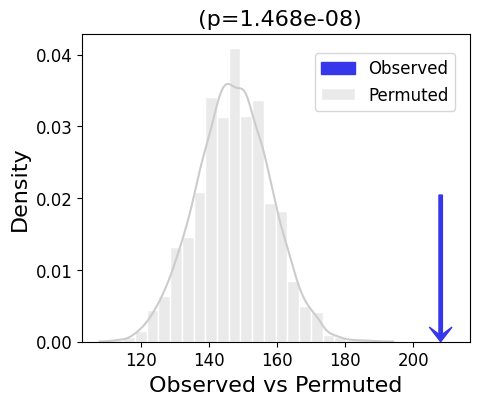

In [19]:
#loop over all rare and common
#plot network enrichment histograms

zlist = [1,1.5,2,3,4,5]
z12list = [1,1.5,2,3,4,5]

cutoff_single=1.5
cutoff_comb=3
for row_rare in range(len(rare_datasets)):
    label_rare=rare_datasets['label'][row_rare]
    print('analyzing rare dataset: '+label_rare)
    #import rare seed gene list and NPS scores
    seed_rare=import_seedgenes(path='input_files/'+rare_datasets['seed_path'][row_rare],
                               pcol=None,
                               gene_col=rare_datasets['seed_gene_name'],
                                delim=rare_datasets['delim'][row_rare])
    seed_rare=list(set(seed_rare[rare_datasets['seed_gene_name'][row_rare]]))
    zscore_rare_df=import_nps_zscores(z_path='calculated_values/'+rare_datasets['zscore_path'][row_rare], interactome_name='pcnet_v14')
    for row_common in range(len(common_datasets)):
        label_common=common_datasets['label'][row_common]
        print('analyzing common dataset: '+label_common)
        #import common seed gene list and NPS scores
        seed_common=import_seedgenes(path='input_files/'+common_datasets['seed_path'][row_common],
                                    pcol=common_datasets['seed_p'][row_common], 
                                    gene_col=common_datasets['seed_gene_name'][row_common],
                                    delim=common_datasets['delim'][row_common],
                                    cutoff=common_datasets['cutoff'][row_common])
        zscore_common_df=import_nps_zscores(z_path='calculated_values/'+common_datasets['zscore_path'][row_common], interactome_name='pcnet_v14')

        cutoff_single=1.5
        cutoff_comb=3
        observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(zscore_common_df.iloc[:,0], zscore_rare_df.iloc[:,0], 
                                                                    z_score_threshold=cutoff_comb, z1_threshold=cutoff_single,
                                                                    z2_threshold=cutoff_single, num_reps=10000, plot=False)                                                                   
    plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted", color=color_dict['other'], arrow_color=color_dict['shared'])
        